In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py
from collections import defaultdict

from astropy.cosmology import Planck18
cosmo = Planck18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### check runs

In [2]:
wdir = '/ocean/projects/phy240015p/mho1/cmass-ili'
wdir = '/anvil/scratch/x-mho1/cmass-ili'

# nbody = 'abacuslike'
# sim = 'fastpm'
# L, N = 2000, 256

# nbody = 'abacuslike'
# sim = 'pinocchio'
# L, N = 2000, 1024

nbody = 'abacus'
sim = 'nbody'
L, N = 2000, 256

# nbody = 'quijote'
# sim = 'nbody'
# L, N = 1000, 128

# nbody = 'quijotelike'
# sim = 'fastpm'
# L, N = 1000, 128

# nbody = 'quijotelike'
# sim = 'pinocchio'
# L, N = 1000, 512

# nbody = 'mtnglike'
# sim = 'fastpm'
# L, N = 3000, 384

suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')

In [ ]:
# ~~~ RHO/HALOS ~~~
tracer = 'halos.h5'

assert tracer in ['rho.h5', 'halos.h5']

if 'quijote' in nbody:
    Lmax = 1000
elif 'abacus' in nbody:
    Lmax = 2000
elif 'mtng' in nbody:
    Lmax = 3000
else:
    raise ValueError(nbody)
kF = 2*np.pi/Lmax

c = defaultdict(list)
for lhid in tqdm(os.listdir(suitedir)[:]):  # iterate through simulations
    diagdir = join(suitedir, lhid, 'diag')
    lhid = int(lhid)
    c['dir'].append(lhid)

    # check if tracer exists
    if not os.path.exists(join(diagdir, tracer)):
        continue
    c[tracer].append(lhid)

    # for each snapshot in tracer, check the summaries
    try:
        with h5py.File(join(diagdir, tracer), 'a') as f:
            for k in f.keys():
                for l in f[k].keys():
                    s = f[k][l].shape
                    c[f'{k}  {l}  {s}'].append(lhid)

                # Remove old runs (optional)
                if 'Bk' not in f[k]:
                    c['no Bk!'].append(lhid)

                    # os.remove(join(diagdir, tracer))
                    break

                # Check for old Bks (optional)
                if f[k]['Bk'].shape[0] > 1:
                    c['old Bkshape!'].append(lhid)

                    # os.remove(join(diagdir, tracer))
                    break

                # fix kF (optional)
                x = f[k]['Bk_k123'][:]
                y = f[k]['Bk'][:]
                if np.any(x > 1):
                    c['kF not fixed'].append(lhid)
                    # del f[k]['Bk_k123']
                    # f[k]['Bk_k123'] = x*kF
                    # print(x[:, 0])
                    # print(x[:, -1])
    except OSError:
        c['corrupted'].append(lhid)
        # os.remove(join(diagdir, tracer))

100%|██████████| 52/52 [00:00<00:00, 188.63it/s]


In [27]:
for k, v in c.items():
    s = ''
    for t in k.split('  '):
        s += t.ljust(10)
    print(s, len(v))

dir        52
halos.h5   51
0.666667  Bk        (1, 1444)  51
0.666667  Bk_k123   (3, 1444)  51
0.666667  Pk        (443, 3)   51
0.666667  Pk_k3D    (443,)     51
0.666667  Qk        (1, 1444)  51
0.666667  bPk       (3, 1444)  51
0.666667  bPk_k3D   (3, 1444)  51
0.666667  mass_bins (100,)     51
0.666667  mass_hist (99,)      51
0.666667  zBk       (1, 1444)  51
0.666667  zBk_k123  (3, 1444)  51
0.666667  zPk       (443, 3)   51
0.666667  zPk_k3D   (443,)     51
0.666667  zQk       (1, 1444)  51
0.666667  zbPk      (3, 1444)  51
0.666667  zbPk_k3D  (3, 1444)  51


In [14]:
# ~~~ GALAXIES ~~~

tracer = 'galaxies'

assert tracer.endswith('galaxies')


if 'quijote' in nbody:
    Lmax = 1000
elif 'abacus' in nbody:
    Lmax = 2000
elif 'mtng' in nbody:
    Lmax = 3000
else:
    raise ValueError(nbody)
kF = 2*np.pi/Lmax

c = defaultdict(list)
for lhid in tqdm(os.listdir(suitedir)[:]):  # iterate through simulations
    diagdir = join(suitedir, lhid, 'diag')
    lhid = int(lhid)
    c['dir'].append(lhid)

    # check if tracer directory exists
    if not os.path.exists(join(diagdir, tracer)):
        continue

    # for each file in the tracer directory, check the summaries
    for file in os.listdir(join(diagdir, tracer)):
        c[tracer].append(lhid)
        with h5py.File(join(diagdir, tracer, file), 'a') as f:
            for k in f.keys():
                for l in f[k].keys():
                    s = f[k][l].shape
                    c[f'{k}  {l}  {s}'].append(lhid)

                # Remove old runs (optional)
                if 'Bk' not in f[k]:
                    c['no Bk!'].append(lhid)

                    # os.remove(join(diagdir, tracer, file))
                    break

                # Check for old Bks (optional)
                if f[k]['Bk'].shape[0] > 1:
                    c['old Bkshape!'].append(lhid)

                    # os.remove(join(diagdir, tracer, file))
                    break

                # fix kF (optional)
                x = f[k]['Bk_k123'][:]
                if np.any(x > 1):
                    c['kF not fixed'].append(lhid)
                    # del f[k]['Bk_k123']
                    # f[k]['Bk_k123'] = x*kF
                    # print(x[:, 0])
                    # print(x[:, -1])

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 93.71it/s]


In [15]:
for k, v in c.items():
    s = ''
    for t in k.split('  '):
        s += t.ljust(15)
    print(s, len(v))

dir             52
galaxies        260
0.666667       Bk             (1, 1444)       259
0.666667       Bk_k123        (3, 1444)       259
0.666667       Pk             (443, 3)        259
0.666667       Pk_k3D         (443,)          259
0.666667       Qk             (1, 1444)       259
0.666667       bPk            (3, 1444)       259
0.666667       bPk_k3D        (3, 1444)       259
0.666667       zBk            (1, 1444)       259
0.666667       zBk_k123       (3, 1444)       259
0.666667       zPk            (443, 3)        259
0.666667       zPk_k3D        (443,)          259
0.666667       zQk            (1, 1444)       259
0.666667       zbPk           (3, 1444)       259
0.666667       zbPk_k3D       (3, 1444)       259


In [ ]:
# ~~~ LIGHTCONE ~~~

tracer = 'sgc_lightcone'

assert tracer.endswith('lightcone')

if tracer.startswith('sgc'):
    Lmax = 2500
elif tracer.startswith('ngc'):
    Lmax = 3500
elif tracer.startswith('mtng'):
    Lmax = 2000
else:
    raise ValueError(tracer)
kF = 2*np.pi/Lmax

c = defaultdict(list)
for lhid in tqdm(os.listdir(suitedir)[:]):  # iterate through simulations
    diagdir = join(suitedir, lhid, 'diag')
    lhid = int(lhid)
    c['dir'].append(lhid)

    # check if tracer directory exists
    if not os.path.exists(join(diagdir, tracer)):
        continue

    # for each file in the tracer directory, check the summaries
    for file in os.listdir(join(diagdir, tracer)):
        c[tracer].append(lhid)
        with h5py.File(join(diagdir, tracer, file), 'a') as f:
            for k in f.keys():
                s = f[k].shape
                c[f'{k}  {s}'].append(lhid)

            # Remove old runs (optional)
            if 'Bk' not in f:
                c['no Bk!'].append(lhid)

                # os.remove(join(diagdir, tracer))
                break

            # Check for old Bks (optional)
            if f['Bk'].shape[0] > 1:
                c['old Bkshape!'].append(lhid)

                # os.remove(join(diagdir, tracer))
                break

            # fix kF (optional)
            x = f['Bk_k123'][:]
            if np.any(x > 1):
                c['kF not fixed'].append(lhid)
                # del f[k]['Bk_k123']
                # f[k]['Bk_k123'] = x*kF
                # print(x[:, 0])
                # print(x[:, -1])

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:02<00:00, 21.03it/s]


In [29]:
for k, v in c.items():
    s = ''
    for t in k.split('  '):
        s += t.ljust(15)
    print(s, len(v))

dir             52
sgc_lightcone   259
Bk             (1, 1444)       259
Bk_k123        (3, 1444)       259
Pk             (443, 3)        259
Pk_k3D         (443,)          259
Qk             (1, 1444)       259
bPk            (3, 1444)       259
bPk_k3D        (3, 1444)       259


### Extra collation

In [ ]:
# check missing runs
','.join([str(i-2000) for i in range(3000) if i not in c['Bk']])

'-1984,-1834,-1600,-1181,-1179,-1067,-799,-326,-181,-169,-124,150,963'

In [ ]:
# mtng
unique_values, counts = np.unique(c['Bk'], return_counts=True)
unique_counts = dict(zip(unique_values, counts))

rerun = []
for k, v in unique_counts.items():
    if v < 5:
        rerun.append(k)
rerun = np.array(rerun)
print(','.join(rerun.astype(str)))

44,94,98,113,132,179,182,186,407,415,478,485,642,648,911,1043,1142,1163,1594,1705,1837,1838,1954,2058,2140,2250,2263,2311,2328,2474,2588,2695,2739,2770,2869,2932,2934,2991


In [78]:
# ngc
unique_values, counts = np.unique(c['Bk'], return_counts=True)
unique_counts = dict(zip(unique_values, counts))

rerun2 = []
for k, v in unique_counts.items():
    if v < 5:
        rerun2.append(k)
rerun2 = np.array(rerun2)
print(','.join(rerun2.astype(str)))

13,23,25,44,57,94,113,132,179,182,186,305,371,478,485,601,610,618,642,648,703,710,911,1004,1010,1043,1102,1142,1163,1170,1202,1272,1276,1379,1477,1594,1602,1616,1705,1770,1837,1838,1866,1901,1904,1954,2004,2058,2066,2072,2102,2140,2170,2175,2250,2263,2319,2325,2328,2353,2377,2410,2474,2588,2739,2869,2877,2932,2934,2977,2991


In [26]:
combined = np.concatenate([rerun, rerun2])
combined = np.unique(combined)
# print(','.join(np.sort(combined).astype(str)))
print("0-1000:", ','.join(np.sort(combined[combined < 1000]).astype(str)))
print("2000+:", ','.join(np.sort(combined[combined >= 2000]-2000).astype(str)))

0-1000: 2,6,10,13,19,23,25,44,57,76,94,98,113,132,179,182,186,201,204,265,305,357,371,401,407,415,457,472,475,478,485,501,506,553,601,610,618,642,648,675,703,710,719,757,857,871,911,916,919
2000+: 4,58,66,71,72,102,103,140,170,175,250,263,311,319,325,328,353,377,410,474,588,625,695,713,739,770,869,877,932,934,965,972,977,991


In [18]:
pk_set = set(c['Pk'])
qk_set = set(c['Qk'])

pk_not_in_qk = pk_set - qk_set

print(sorted(pk_not_in_qk))

[1, 2, 3, 4, 5, 6, 10, 13, 16, 18, 19, 23, 25, 53, 57, 59, 65, 66, 70, 71, 72, 75, 76, 77, 79, 85, 101, 102, 103, 104, 105, 106, 110, 113, 116, 118, 119, 123, 125, 153, 157, 159, 165, 166, 170, 171, 172, 175, 176, 177, 179, 185, 201, 202, 203, 204, 205, 206, 210, 213, 216, 218, 219, 223, 225, 253, 257, 259, 265, 266, 270, 271, 272, 275, 276, 277, 279, 285, 301, 302, 303, 304, 305, 306, 310, 313, 316, 318, 319, 323, 325, 353, 357, 359, 365, 366, 370, 371, 372, 375, 376, 377, 379, 385, 453, 457, 459, 465, 466, 470, 471, 472, 475, 476, 477, 479, 485, 501, 502, 503, 504, 505, 506, 510, 513, 516, 518, 519, 523, 525, 553, 557, 559, 565, 566, 570, 571, 572, 575, 576, 577, 579, 585, 601, 602, 603, 604, 605, 606, 610, 613, 616, 618, 619, 623, 625, 653, 657, 659, 665, 666, 670, 671, 672, 675, 676, 677, 679, 685, 701, 702, 703, 704, 705, 706, 710, 713, 716, 718, 719, 723, 725, 753, 757, 759, 765, 766, 770, 771, 772, 775, 776, 777, 779, 785, 801, 802, 803, 804, 805, 806, 810, 813, 816, 818, 819, 8

In [7]:
tracer = 'sgc_lightcone'

c = defaultdict(list)
for lhid in tqdm(os.listdir(suitedir)):
    diagdir = join(suitedir, lhid, 'diag')
    lhid = int(lhid)

    c['dir'].append(lhid)
    if not os.path.exists(join(diagdir, tracer)):
        continue
    for file in os.listdir(join(diagdir, tracer)):
        with h5py.File(join(diagdir, tracer, file), 'r') as f:
            for k in f.keys():
                s = f[k].shape
                c[f'{k} {s}'].append(lhid)
                # if k == 'Bk' and s[0] == 2:
                #     os.remove(join(diagdir, tracer, file))
            if ('Pk' in f.keys()) and ('Bk' not in f.keys()):
                c['Pk only'].append(lhid)
                # os.remove(join(diagdir, tracer, file))

100%|██████████| 52/52 [00:00<00:00, 99.35it/s] 


In [8]:
for k, v in c.items():
    print(k, len(v))

dir 52
Bk (1, 1444) 259
Bk_k123 (3, 1444) 259
Pk (443, 3) 259
Pk_k3D (443,) 259
Qk (1, 1444) 259
bPk (3, 1444) 259
bPk_k3D (3, 1444) 259


### Check values

In [ ]:
diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacus/fastpm/L2000-N256/130/diag/halos.h5'
a = '0.666667'

out1 = {}
with h5py.File(diagfile, 'r') as f:
    for k in f[a].keys():
        out1[k] = f[a][k][()]


diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacus/nbody/L2000-N256/130/diag/halos.h5'
a = '0.666667'

out2 = {}
with h5py.File(diagfile, 'r') as f:
    for k in f[a].keys():
        out2[k] = f[a][k][()]

In [ ]:
def load_ratio(lhid):
    diagfile = join('/anvil/scratch/x-mho1/cmass-ili/abacus/fastpm/L2000-N256',
                    str(lhid), 'diag', 'halos.h5')
    a = '0.666667'
    out1 = {}
    with h5py.File(diagfile, 'r') as f:
        for k in f[a].keys():
            out1[k] = f[a][k][()]

    diagfile = join('/anvil/scratch/x-mho1/cmass-ili/abacus/nbody/L2000-N256',
                    str(lhid), 'diag', 'halos.h5')
    a = '0.666667'
    out2 = {}
    with h5py.File(diagfile, 'r') as f:
        for k in f[a].keys():
            out2[k] = f[a][k][()]

    out = {}
    for k in out1:
        out[k] = out1[k] / out2[k]
    return out


outs = [load_ratio(lhid) for lhid in range(130, 147)]
out = {k: np.array([o[k] for o in outs]) for k in outs[0]}


diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacus/nbody/L2000-N256/130/diag/halos.h5'
a = '0.666667'
ks = {}
with h5py.File(diagfile, 'r') as f:
    for k in ['Pk_k3D', 'Bk_k123', 'bPk_k3D']:
        ks[k] = f[a][k][()]

/tmp/ipykernel_620031/3439848210.py:20: RuntimeWarning: divide by zero encountered in divide
  out[k] = out1[k] / out2[k]
/tmp/ipykernel_620031/3439848210.py:20: RuntimeWarning: invalid value encountered in divide
  out[k] = out1[k] / out2[k]


In [ ]:
def get_equilateral(k123, Bk):
    ks = np.unique(k123)
    out = np.zeros((*Bk.shape[:-1], len(ks)))
    for i, k in enumerate(ks):
        mask = (k123 == k).all(axis=0)
        out[..., i] = Bk[..., mask]
    return ks, out


def get_squeezed(k123, Bk):
    mask = (k123[0] > k123[1]) & (k123[1] > k123[2])
    return k123[..., mask], Bk[..., mask]

(0.8, 1.2)

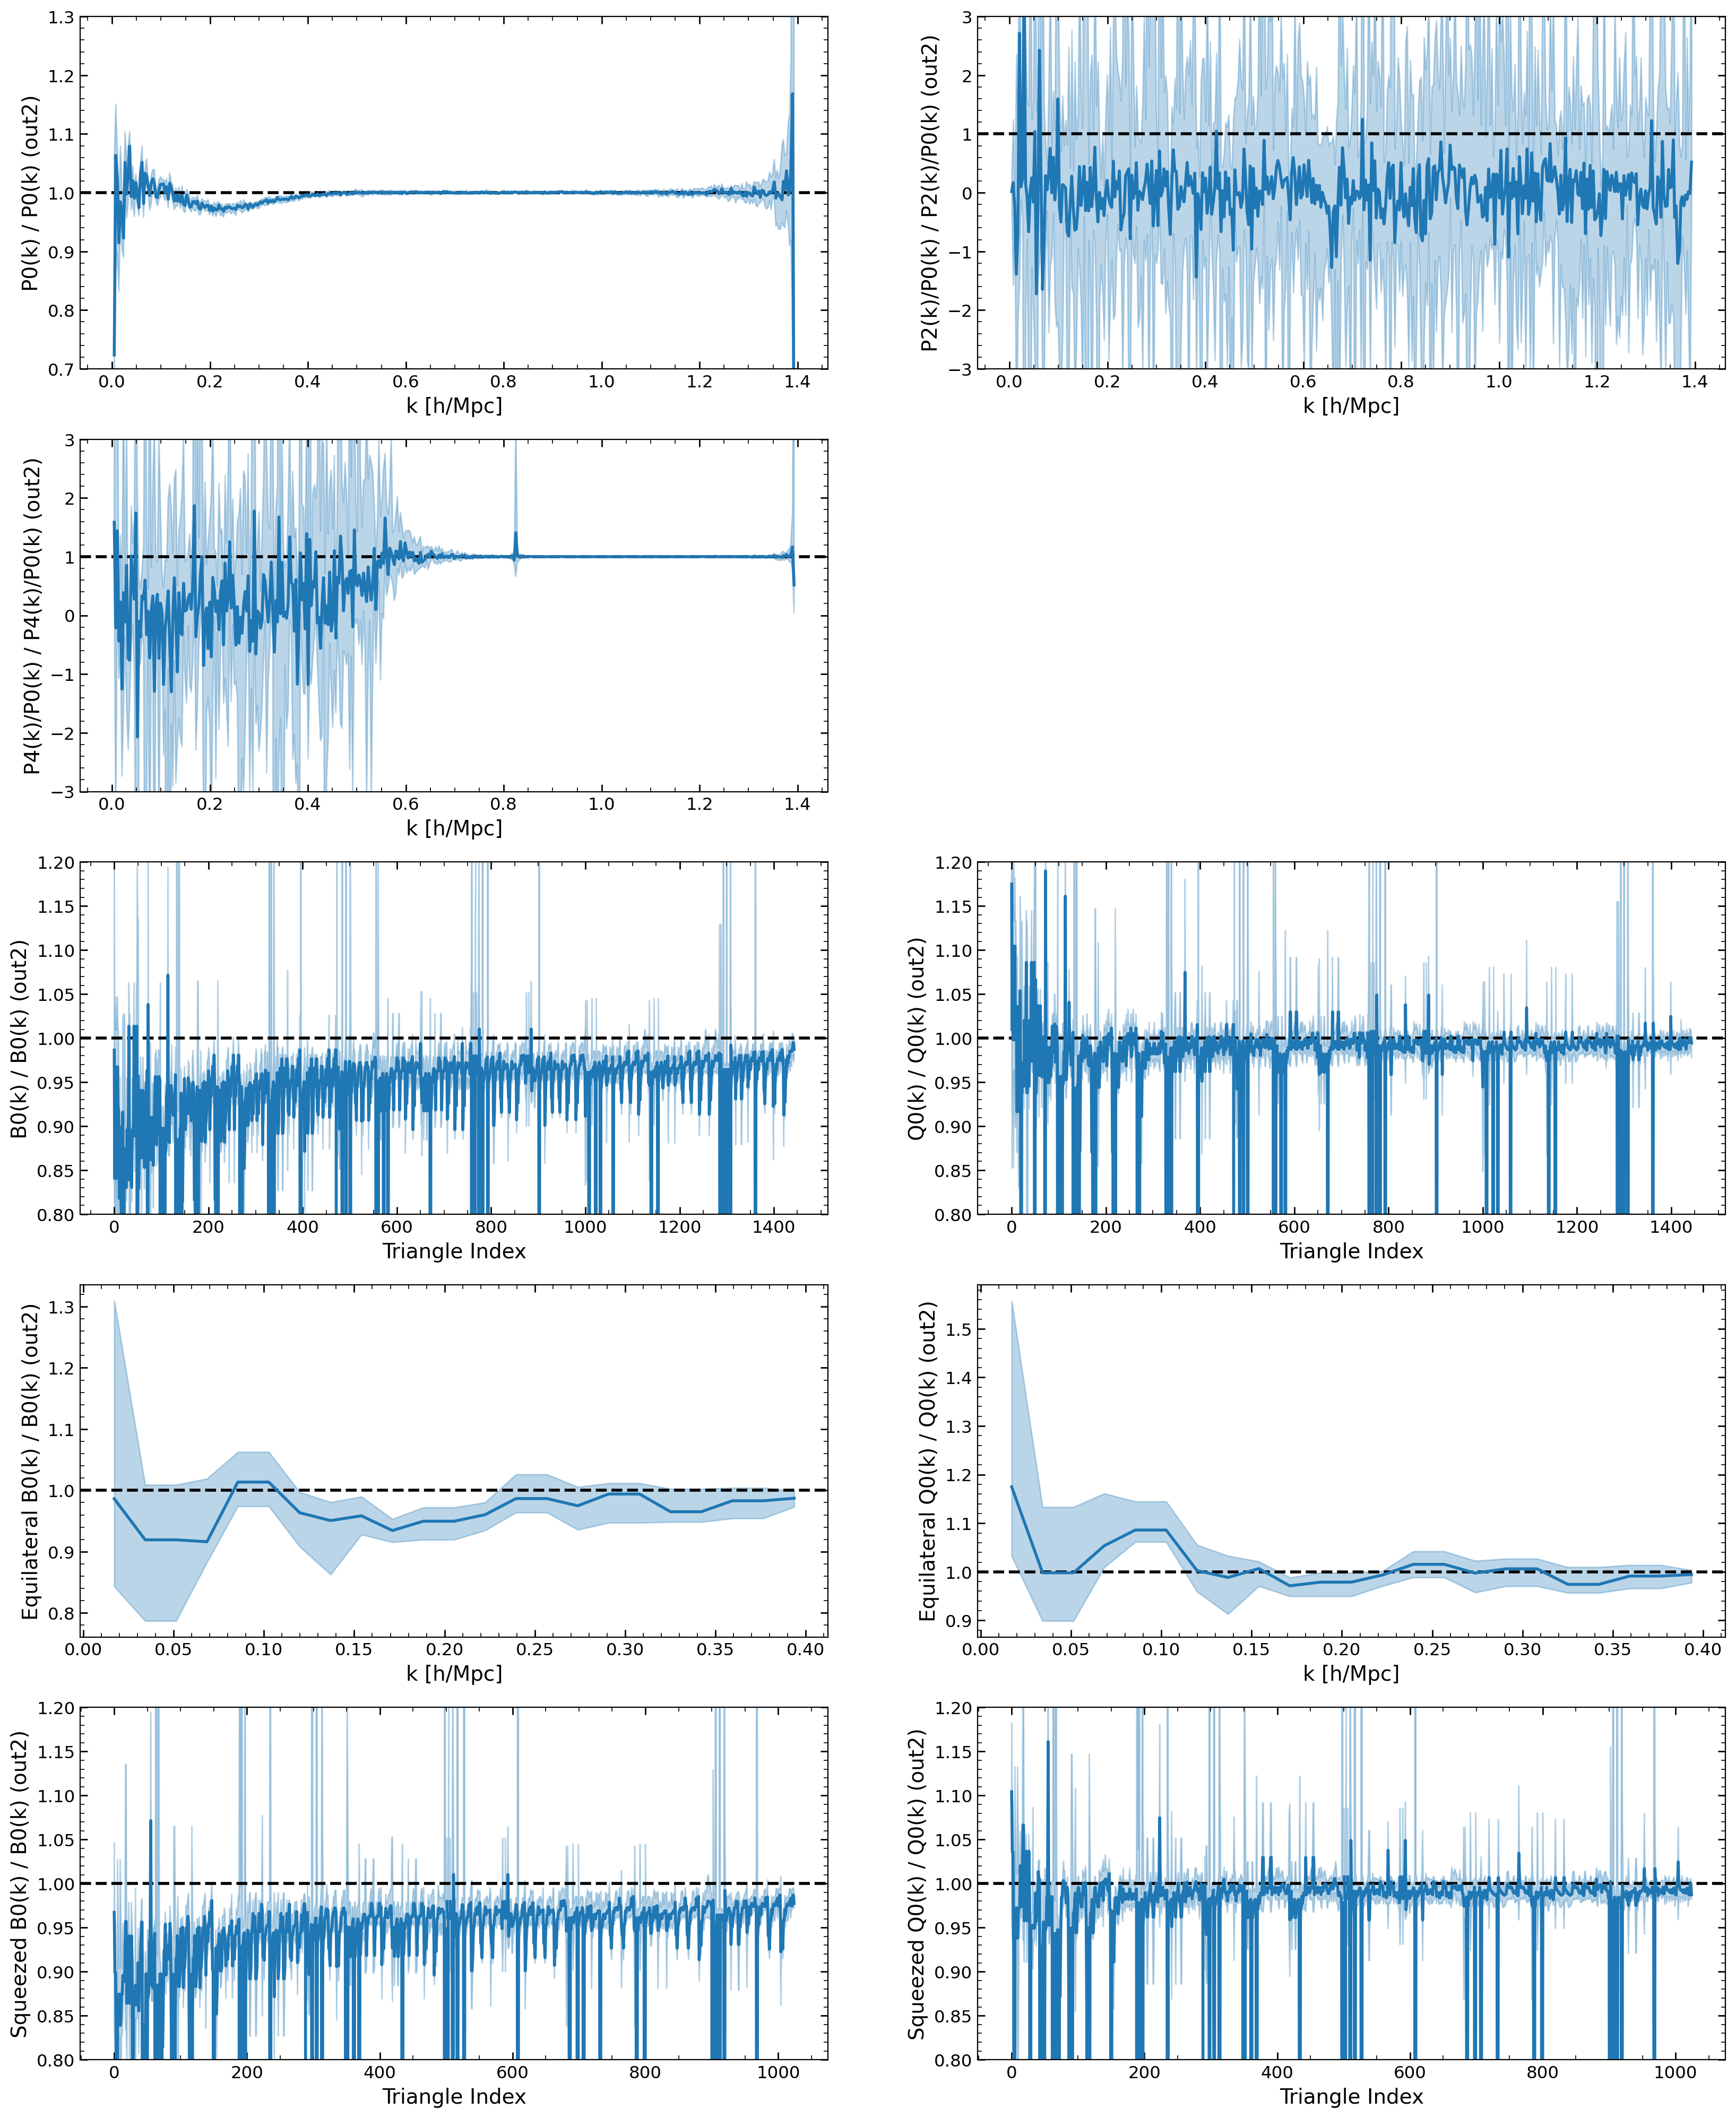

In [ ]:
def plot_ratio(x, y, ax):
    percs = np.percentile(y, [50, 16, 84], axis=0)
    ax.plot(x, percs[0], color='C0')
    ax.fill_between(x, percs[1], percs[2], color='C0', alpha=0.3)


f, axs = plt.subplots(5, 2, figsize=(20, 25))

ax = axs[0, 0]
ax.axhline(1, color='k', ls='--')
plot_ratio(ks['Pk_k3D'], out['Pk'][:, :, 0], ax)
ax.set(xlabel='k [h/Mpc]', ylabel='P0(k) / P0(k) (out2)')
ax.set_ylim(0.7, 1.3)

ax = axs[0, 1]
ax.axhline(1, color='k', ls='--')
plot_ratio(ks['Pk_k3D'], out['Pk'][:, :, 1], ax)
ax.set(xlabel='k [h/Mpc]', ylabel='P2(k)/P0(k) / P2(k)/P0(k) (out2)')
ax.set_ylim(-3, 3)

ax = axs[1, 0]
ax.axhline(1, color='k', ls='--')
plot_ratio(ks['Pk_k3D'], out['Pk'][:, :, 2], ax)
ax.set(xlabel='k [h/Mpc]', ylabel='P4(k)/P0(k) / P4(k)/P0(k) (out2)')
ax.set_ylim(-3, 3)

axs[1, 1].axis('off')

ax = axs[2, 0]
ax.axhline(1, color='k', ls='--')
plot_ratio(range(len(ks['Bk_k123'][0])), out['Bk'][:, 0], ax)
ax.set(xlabel='Triangle Index', ylabel='B0(k) / B0(k) (out2)')
ax.set_ylim(0.8, 1.2)

ax = axs[2, 1]
ax.axhline(1, color='k', ls='--')
plot_ratio(range(len(ks['Bk_k123'][0])), out['Qk'][:, 0], ax)
ax.set(xlabel='Triangle Index', ylabel='Q0(k) / Q0(k) (out2)')
ax.set_ylim(0.8, 1.2)

ax = axs[3, 0]
ax.axhline(1, color='k', ls='--')
xs, ys = zip(*[get_equilateral(ks['Bk_k123'], out['Bk'][i])
             for i in range(len(out['Bk']))])
xs, ys = np.array(xs), np.array(ys)
plot_ratio(xs[0], ys[:, 0], ax)
ax.set(xlabel='k [h/Mpc]', ylabel='Equilateral B0(k) / B0(k) (out2)')

ax = axs[3, 1]
ax.axhline(1, color='k', ls='--')
xs, ys = zip(*[get_equilateral(ks['Bk_k123'], out['Qk'][i])
             for i in range(len(out['Qk']))])
xs, ys = np.array(xs), np.array(ys)
plot_ratio(xs[0], ys[:, 0], ax)
ax.set(xlabel='k [h/Mpc]', ylabel='Equilateral Q0(k) / Q0(k) (out2)')

ax = axs[4, 0]
ax.axhline(1, color='k', ls='--')
xs, ys = zip(*[get_squeezed(ks['Bk_k123'], out['Bk'][i])
             for i in range(len(out['Bk']))])
xs, ys = np.array(xs), np.array(ys)
plot_ratio(range(ys.shape[-1]), ys[:, 0], ax)
ax.set(xlabel='Triangle Index', ylabel='Squeezed B0(k) / B0(k) (out2)')
ax.set_ylim(0.8, 1.2)

ax = axs[4, 1]
ax.axhline(1, color='k', ls='--')
xs, ys = zip(*[get_squeezed(ks['Bk_k123'], out['Qk'][i])
             for i in range(len(out['Qk']))])
xs, ys = np.array(xs), np.array(ys)
plot_ratio(range(ys.shape[-1]), ys[:, 0], ax)
ax.set(xlabel='Triangle Index', ylabel='Squeezed Q0(k) / Q0(k) (out2)')
ax.set_ylim(0.8, 1.2)

In [42]:
ys.shape

(17, 1, 1025)

### Check open triangles

In [38]:
openfile = '/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/L1000-N128/0/diag/halos0.h5'
closefile = '/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/L1000-N128/0/diag/halos.h5'
a = '0.666667'

odict = {}
with h5py.File(openfile, 'r') as f:
    for k in f[a].keys():
        odict[k] = f[a][k][()]

cdict = {}
with h5py.File(closefile, 'r') as f:
    for k in f[a].keys():
        cdict[k] = f[a][k][()]

for k, v in odict.items():
    print(k, v.shape)
for k, v in cdict.items():
    print(k, v.shape)

Bk (1, 1444)
Bk_k123 (3, 1444)
Pk (221, 3)
Pk_k3D (221,)
Qk (1, 1444)
bPk (3, 1444)
bPk_k3D (3, 1444)
mass_bins (100,)
mass_hist (99,)
zBk (1, 1444)
zBk_k123 (3, 1444)
zPk (221, 3)
zPk_k3D (221,)
zQk (1, 1444)
zbPk (3, 1444)
zbPk_k3D (3, 1444)
Bk (1, 1239)
Bk_k123 (3, 1239)
Pk (221, 3)
Pk_k3D (221,)
Qk (1, 1239)
bPk (3, 1239)
bPk_k3D (3, 1239)
mass_bins (100,)
mass_hist (99,)
zBk (1, 1239)
zBk_k123 (3, 1239)
zPk (221, 3)
zPk_k3D (221,)
zQk (1, 1239)
zbPk (3, 1239)
zbPk_k3D (3, 1239)


In [40]:
# k = cdict['Bk_k123']
# m = k[0] >= k[1]+k[2]
# plt.plot(k[:, m].T)

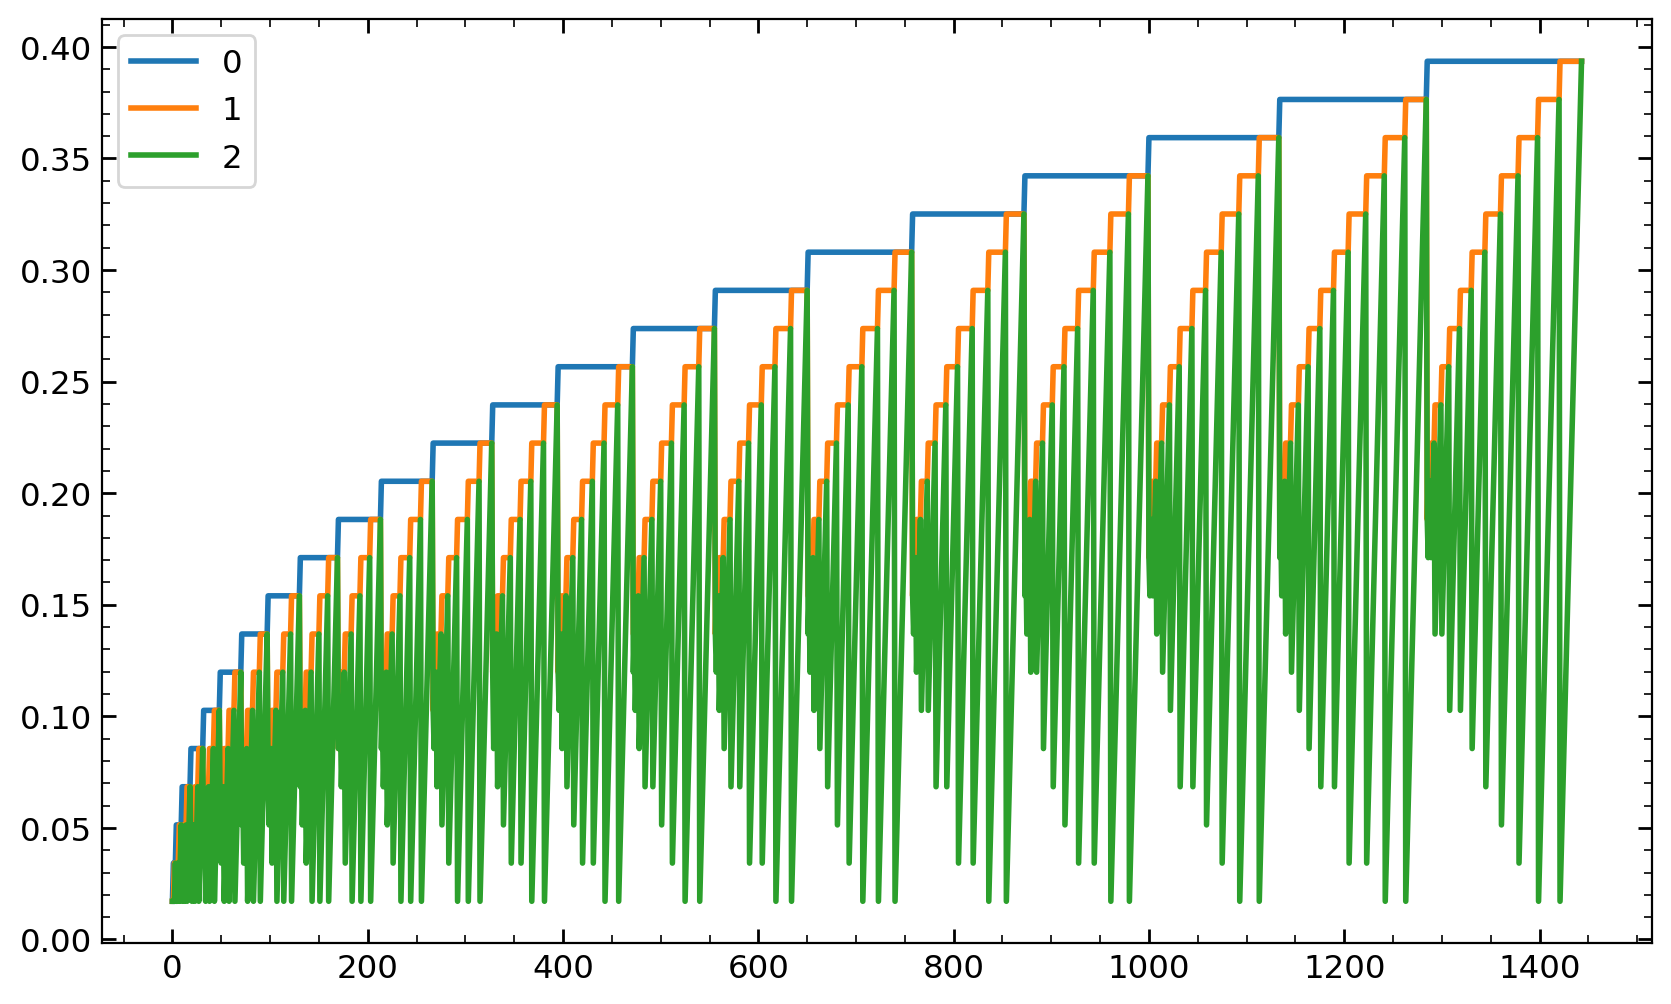

In [41]:
k = odict['Bk_k123']
for i, x in enumerate(k):
    plt.plot(x, label=i)
plt.legend()

Text(0.5, 1.0, 'open_triangles=False')

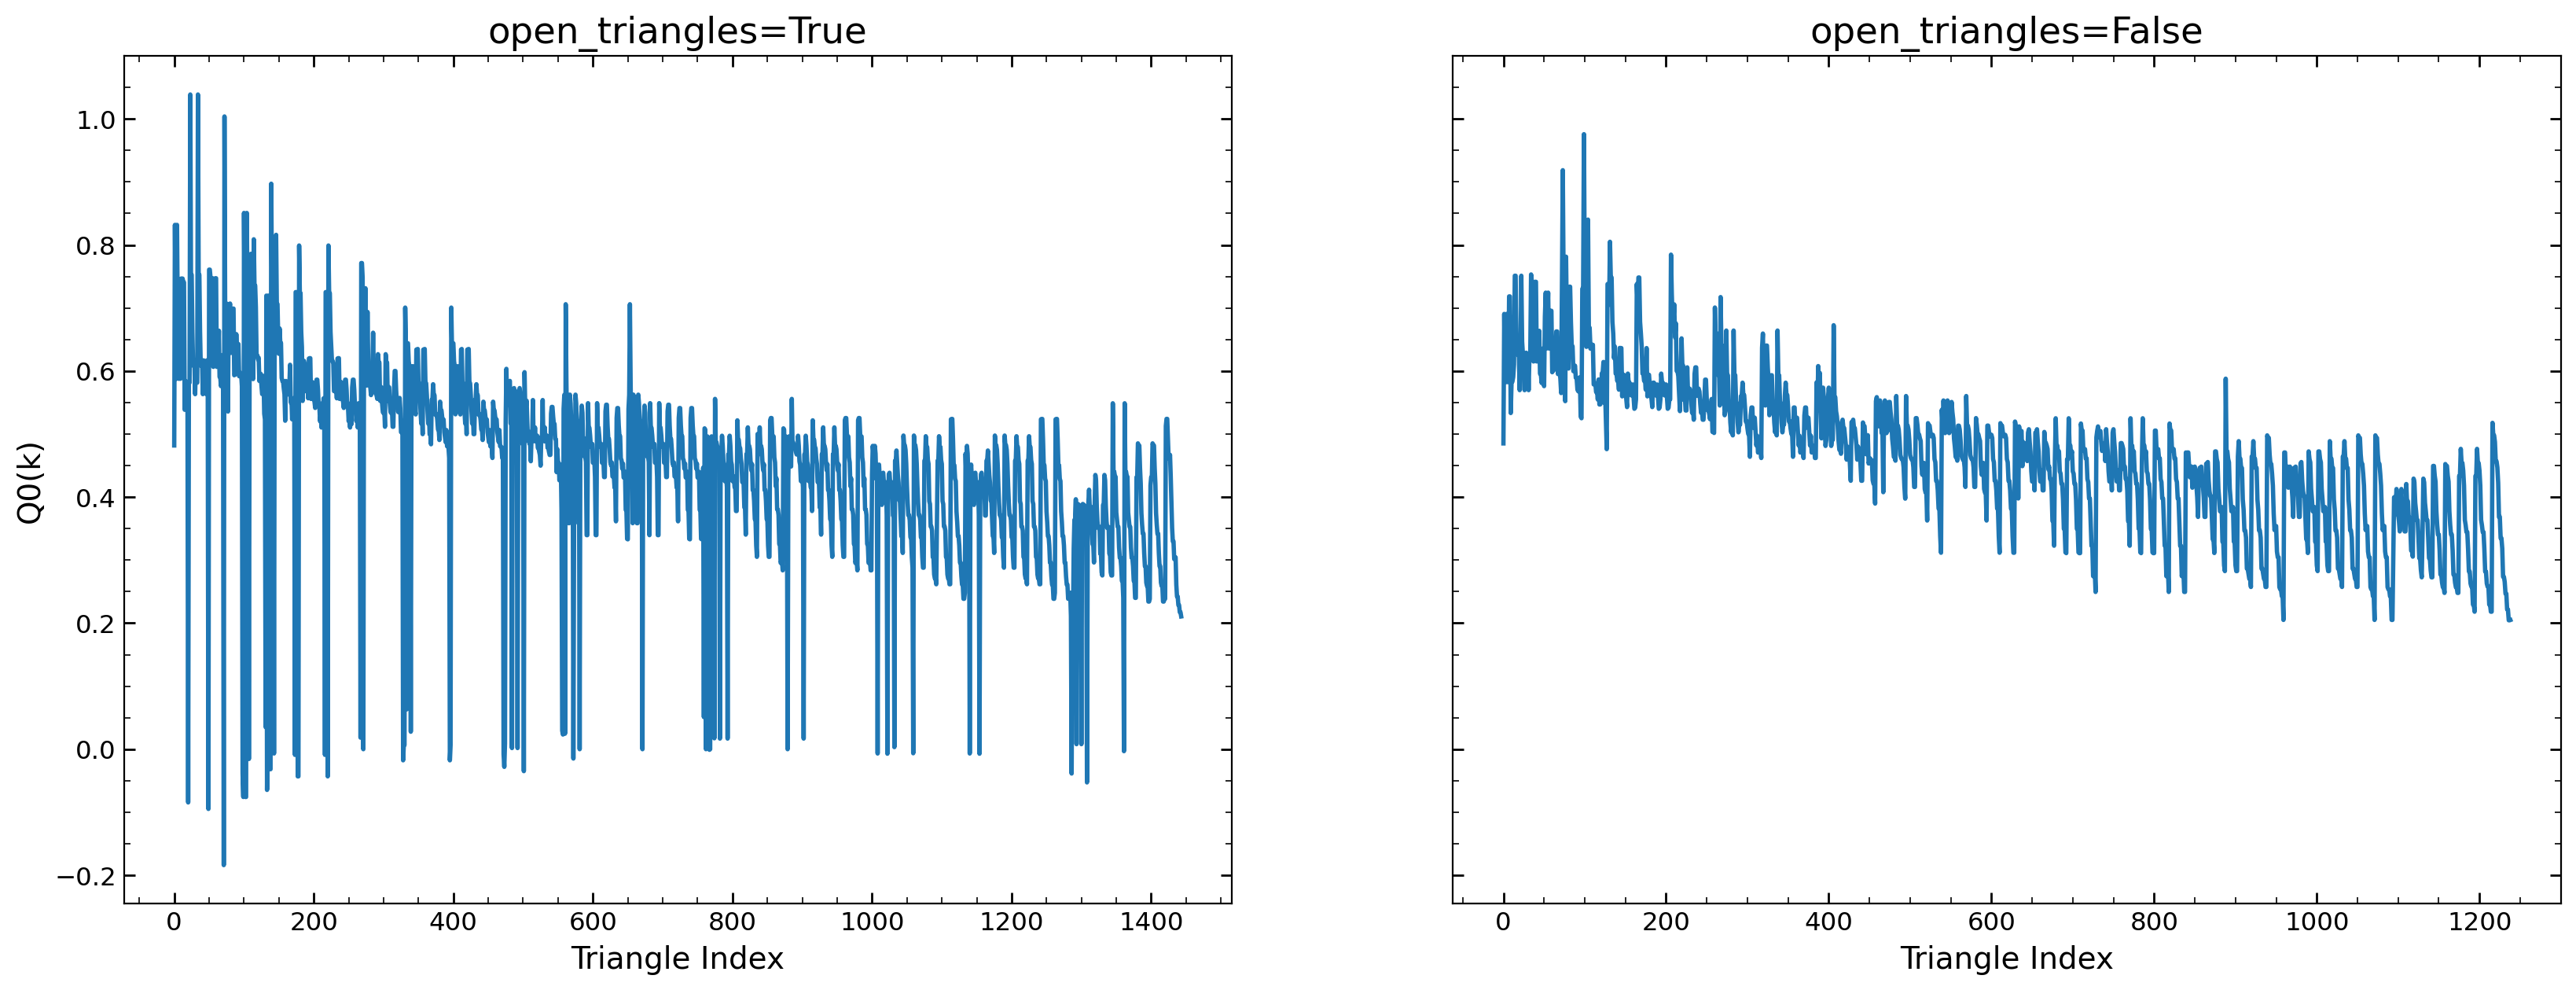

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=True,
                      gridspec_kw={'hspace': 0.1})
ax = axs[0]
ax.plot(odict['Qk'][0])
ax.set(xlabel='Triangle Index', ylabel='Q0(k)')
ax.set_title('open_triangles=True')
ax = axs[1]
ax.plot(cdict['Qk'][0])
ax.set(xlabel='Triangle Index')
ax.set_title('open_triangles=False')